# Volatility Forecasting Model for CME Globex Futures

**Tested and verified to work with Databento GLBX-MDP3 trade data.**

This notebook builds a machine learning model to predict future realized volatility.

**Strategy:** Predict whether volatility over the next hour will be higher or lower than current volatility.

## 1. Setup & Imports

In [10]:
# Install required packages (uncomment if needed)
!pip install zstandard pandas numpy scikit-learn xgboost matplotlib seaborn joblib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [11]:
import os
import sys
import ctypes

# Fix XGBoost OpenMP library path for macOS (ARM64)
# Load libomp library directly before importing xgboost
try:
    libomp_path = '/opt/homebrew/opt/libomp/lib/libomp.dylib'
    ctypes.CDLL(libomp_path)
    print(f'✓ Successfully loaded OpenMP library from {libomp_path}')
except Exception as e:
    print(f'✗ Warning: Could not preload OpenMP library: {e}')

import zstandard as zstd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import io
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import xgboost as xgb
import joblib

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
print('✓ All imports successful!')
print(f'✓ XGBoost version: {xgb.__version__}')

✓ Successfully loaded OpenMP library from /opt/homebrew/opt/libomp/lib/libomp.dylib
✓ All imports successful!
✓ XGBoost version: 3.1.3


## 2. Configuration

**Modify DATA_DIR to point to your folder containing .zst files.**

In [12]:
# =============================================================================
# CONFIGURATION - Modify these as needed
# =============================================================================

DATA_DIR = '/Users/mac/projects/options-pricer/data'  # <-- CHANGE THIS TO YOUR DATA PATH
SYMBOL = 'NQZ5'                       # Futures symbol (NQZ5 = Nasdaq Dec 2025)
BAR_FREQ = '5min'                     # Bar frequency
HORIZON = 12                          # Prediction horizon (12 bars = 1 hour)
TRAIN_RATIO = 0.7                     # Train/test split
TRANSACTION_COST = 0.001              # 10 bps round-trip

print(f'Configuration:')
print(f'  Data Directory: {DATA_DIR}')
print(f'  Symbol: {SYMBOL}')
print(f'  Bar Frequency: {BAR_FREQ}')
print(f'  Prediction Horizon: {HORIZON} bars ({HORIZON * 5} minutes)')

Configuration:
  Data Directory: /Users/mac/projects/options-pricer/data
  Symbol: NQZ5
  Bar Frequency: 5min
  Prediction Horizon: 12 bars (60 minutes)


## 3. Data Loading

Load CME Globex MDP3 trade data from zstd-compressed CSV files.

In [13]:
def load_zst_file(filepath):
    """Load a single zstd compressed CSV file"""
    with open(filepath, 'rb') as f:
        dctx = zstd.ZstdDecompressor()
        reader = dctx.stream_reader(f)
        chunks = []
        while True:
            chunk = reader.read(1024 * 1024 * 10)
            if not chunk:
                break
            chunks.append(chunk)
        data = b''.join(chunks)
    return pd.read_csv(io.BytesIO(data))

def load_all_data(data_dir, symbol):
    """Load all glbx-mdp3-*.zst files and filter by symbol"""
    data_path = Path(data_dir)
    files = sorted(data_path.glob('glbx-mdp3-*.zst'))
    
    if not files:
        raise FileNotFoundError(f'No glbx-mdp3-*.zst files found in {data_dir}')
    
    print(f'Found {len(files)} data files')
    
    all_dfs = []
    for f in files:
        print(f'Loading {f.name}...', end=' ')
        try:
            df = load_zst_file(str(f))
            if len(df) > 0 and 'symbol' in df.columns:
                df_filtered = df[df['symbol'] == symbol].copy()
                if len(df_filtered) > 0:
                    all_dfs.append(df_filtered)
                    print(f'{len(df_filtered):,} trades')
                else:
                    print(f'No {symbol} trades')
            else:
                print('Empty or invalid')
        except Exception as e:
            print(f'Error: {e}')
    
    if not all_dfs:
        raise ValueError(f'No data found for symbol {symbol}')
    
    combined = pd.concat(all_dfs, ignore_index=True)
    combined['ts_event'] = pd.to_datetime(combined['ts_event'])
    combined = combined.sort_values('ts_event').reset_index(drop=True)
    return combined

In [14]:
# Load the data
print('='*60)
print('LOADING DATA')
print('='*60)

raw_data = load_all_data(DATA_DIR, SYMBOL)

print(f'\nTotal trades loaded: {len(raw_data):,}')
print(f'Date range: {raw_data["ts_event"].min()} to {raw_data["ts_event"].max()}')

LOADING DATA
Found 78 data files
Loading glbx-mdp3-20250928.trades.csv.zst... 6,116 trades
Loading glbx-mdp3-20250929.trades.csv.zst... 305,444 trades
Loading glbx-mdp3-20250930.trades.csv.zst... 323,754 trades
Loading glbx-mdp3-20251001.trades.csv.zst... 296,345 trades
Loading glbx-mdp3-20251002.trades.csv.zst... 288,910 trades
Loading glbx-mdp3-20251003.trades.csv.zst... 299,362 trades
Loading glbx-mdp3-20251005.trades.csv.zst... 6,943 trades
Loading glbx-mdp3-20251006.trades.csv.zst... 261,794 trades
Loading glbx-mdp3-20251007.trades.csv.zst... 330,479 trades
Loading glbx-mdp3-20251008.trades.csv.zst... 271,412 trades
Loading glbx-mdp3-20251009.trades.csv.zst... 309,551 trades
Loading glbx-mdp3-20251010.trades.csv.zst... 638,311 trades
Loading glbx-mdp3-20251012.trades.csv.zst... 24,115 trades
Loading glbx-mdp3-20251013.trades.csv.zst... 419,151 trades
Loading glbx-mdp3-20251014.trades.csv.zst... 503,379 trades
Loading glbx-mdp3-20251015.trades.csv.zst... 427,202 trades
Loading glbx

In [15]:
raw_data.head(10)

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,ts_in_delta,sequence,symbol
0,2025-09-28T22:00:00.064722086Z,2025-09-28 22:00:00+00:00,0,1,158704,T,N,0,24726.50,16,0,13102,13800,NQZ5
1,2025-09-28T22:00:00.080876962Z,2025-09-28 22:00:00.073502353+00:00,0,1,158704,T,A,0,24721.75,1,0,12252,14120,NQZ5
2,2025-09-28T22:00:00.126809851Z,2025-09-28 22:00:00.098876927+00:00,0,1,158704,T,B,0,24726.00,1,0,11885,14471,NQZ5
3,2025-09-28T22:00:00.229573468Z,2025-09-28 22:00:00.228460783+00:00,0,1,158704,T,B,0,24727.50,2,0,12932,15574,NQZ5
4,2025-09-28T22:00:00.230831869Z,2025-09-28 22:00:00.229590979+00:00,0,1,158704,T,B,0,24727.75,1,0,12202,15583,NQZ5
5,2025-09-28T22:00:00.277947257Z,2025-09-28 22:00:00.276408121+00:00,0,1,158704,T,B,0,24731.75,1,0,12481,15924,NQZ5
6,2025-09-28T22:00:00.277947257Z,2025-09-28 22:00:00.276408121+00:00,0,1,158704,T,B,0,24732.00,2,0,12481,15924,NQZ5
7,2025-09-28T22:00:00.277947257Z,2025-09-28 22:00:00.276408121+00:00,0,1,158704,T,B,0,24732.25,1,0,12481,15924,NQZ5
8,2025-09-28T22:00:00.387528333Z,2025-09-28 22:00:00.386368929+00:00,0,1,158704,T,B,0,24731.75,1,0,12206,16159,NQZ5
9,2025-09-28T22:00:00.405467481Z,2025-09-28 22:00:00.404214081+00:00,0,1,158704,T,B,0,24732.25,1,0,12724,16203,NQZ5


## 4. Create OHLCV Bars

In [16]:
def create_bars(df, freq='5min'):
    """Aggregate tick data into OHLCV bars"""
    df = df.copy()
    df = df.set_index('ts_event')
    df['signed_volume'] = df['size'] * df['side'].map({'B': 1, 'A': -1, 'N': 0})
    
    bars = df.groupby(pd.Grouper(freq=freq)).agg({
        'price': ['first', 'max', 'min', 'last', 'std', 'count'],
        'size': ['sum', 'mean', 'max', 'std'],
        'signed_volume': 'sum'
    })
    
    bars.columns = ['open', 'high', 'low', 'close', 'price_std', 'tick_count',
                    'volume', 'avg_trade_size', 'max_trade_size', 'trade_size_std',
                    'order_flow_imbalance']
    
    bars = bars[bars['volume'] > 0].copy()
    bars['return'] = bars['close'].pct_change()
    bars['log_return'] = np.log(bars['close'] / bars['close'].shift(1))
    bars['range'] = (bars['high'] - bars['low']) / bars['close']
    bars['body'] = abs(bars['close'] - bars['open']) / bars['close']
    bars['upper_wick'] = (bars['high'] - bars[['open', 'close']].max(axis=1)) / bars['close']
    bars['lower_wick'] = (bars[['open', 'close']].min(axis=1) - bars['low']) / bars['close']
    bars['ofi_normalized'] = bars['order_flow_imbalance'] / bars['volume']
    
    return bars

In [17]:
bars = create_bars(raw_data, BAR_FREQ)
print(f'Created {len(bars):,} bars at {BAR_FREQ} frequency')
print(f'Date range: {bars.index.min()} to {bars.index.max()}')

Created 16,241 bars at 5min frequency
Date range: 2025-09-28 22:00:00+00:00 to 2025-12-19 14:25:00+00:00


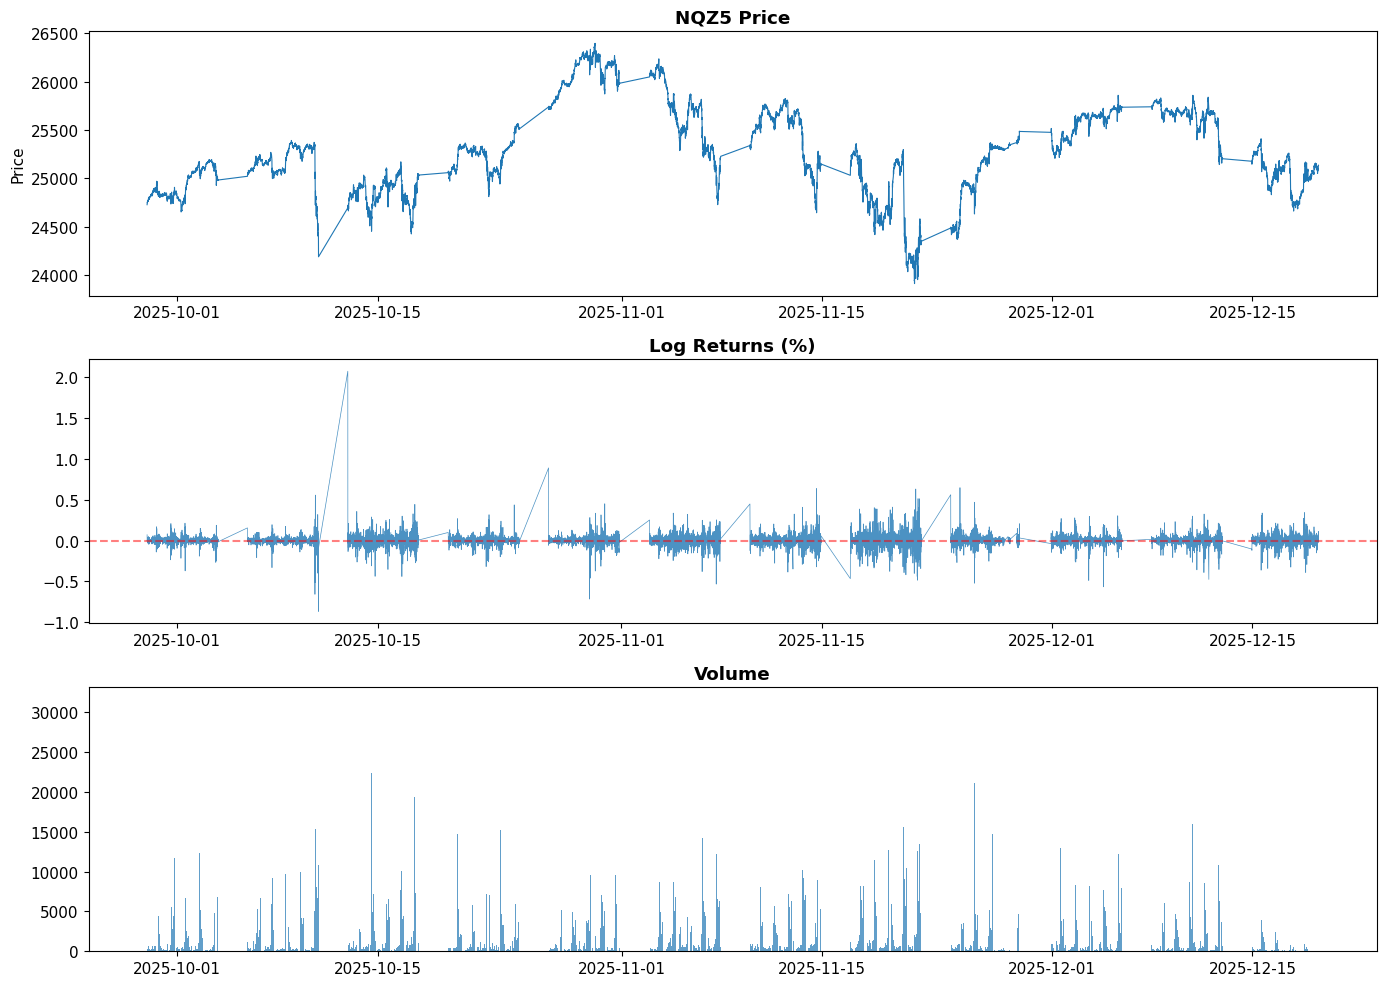

In [18]:
# Visualize
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
axes[0].plot(bars.index, bars['close'], linewidth=0.8)
axes[0].set_title(f'{SYMBOL} Price', fontweight='bold')
axes[0].set_ylabel('Price')
axes[1].plot(bars.index, bars['log_return'] * 100, linewidth=0.5, alpha=0.8)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1].set_title('Log Returns (%)', fontweight='bold')
axes[2].bar(bars.index, bars['volume'], width=0.003, alpha=0.7)
axes[2].set_title('Volume', fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Feature Engineering

In [19]:
def calculate_realized_volatility(returns, window):
    return returns.rolling(window=window).std()

def calculate_parkinson_volatility(high, low, window):
    log_hl = np.log(high / low)
    return np.sqrt((log_hl ** 2).rolling(window=window).mean() / (4 * np.log(2)))

def calculate_garman_klass_volatility(open_, high, low, close, window):
    log_hl = np.log(high / low) ** 2
    log_co = np.log(close / open_) ** 2
    return np.sqrt((0.5 * log_hl - (2 * np.log(2) - 1) * log_co).rolling(window=window).mean())

In [20]:
def create_volatility_features(bars):
    """Create all 65 features for volatility prediction"""
    df = bars.copy()
    
    # Volatility features
    for window in [6, 12, 24, 48, 96]:
        df[f'rvol_{window}'] = calculate_realized_volatility(df['log_return'], window)
    for window in [6, 12, 24, 48]:
        df[f'parkinson_{window}'] = calculate_parkinson_volatility(df['high'], df['low'], window)
    for window in [6, 12, 24, 48]:
        df[f'gk_{window}'] = calculate_garman_klass_volatility(df['open'], df['high'], df['low'], df['close'], window)
    df['vol_of_vol'] = df['rvol_12'].rolling(12).std()
    df['vol_ratio_12_48'] = df['rvol_12'] / df['rvol_48']
    df['vol_ratio_6_24'] = df['rvol_6'] / df['rvol_24']
    
    # Return features
    for lag in [1, 2, 3, 6, 12]:
        df[f'return_lag_{lag}'] = df['log_return'].shift(lag)
    for window in [6, 12, 24]:
        df[f'cum_return_{window}'] = df['log_return'].rolling(window).sum()
    df['return_momentum'] = df['cum_return_6'] - df['cum_return_12'].shift(6)
    for window in [6, 12, 24]:
        df[f'abs_return_ma_{window}'] = df['log_return'].abs().rolling(window).mean()
    df['return_skew_24'] = df['log_return'].rolling(24).skew()
    df['return_kurt_24'] = df['log_return'].rolling(24).kurt()
    
    # Range features
    for window in [6, 12, 24]:
        df[f'range_ma_{window}'] = df['range'].rolling(window).mean()
    df['range_vs_ma'] = df['range'] / df['range_ma_12']
    for window in [12, 24, 48]:
        df[f'range_max_{window}'] = df['range'].rolling(window).max()
    
    # Volume features
    for window in [6, 12, 24, 48]:
        df[f'volume_ma_{window}'] = df['volume'].rolling(window).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma_24']
    df['volume_trend'] = df['volume_ma_6'] / df['volume_ma_24']
    df['volume_std_24'] = df['volume'].rolling(24).std()
    
    # Microstructure features
    for window in [6, 12, 24]:
        df[f'tick_count_ma_{window}'] = df['tick_count'].rolling(window).mean()
    df['tick_intensity_ratio'] = df['tick_count'] / df['tick_count_ma_24']
    for window in [6, 12, 24]:
        df[f'avg_size_ma_{window}'] = df['avg_trade_size'].rolling(window).mean()
    for window in [6, 12, 24]:
        df[f'ofi_ma_{window}'] = df['ofi_normalized'].rolling(window).mean()
    df['ofi_std_24'] = df['ofi_normalized'].rolling(24).std()
    for window in [6, 12, 24]:
        df[f'ofi_cum_{window}'] = df['order_flow_imbalance'].rolling(window).sum()
    
    # Time features
    df['hour'] = df.index.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow'] = df.index.dayofweek
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 5)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 5)
    df['is_us_hours'] = ((df['hour'] >= 14) & (df['hour'] <= 20)).astype(int)
    
    # Interaction features
    df['vol_x_volume'] = df['rvol_12'] * df['volume_ratio']
    df['ofi_x_vol'] = df['ofi_normalized'].abs() * df['rvol_12']
    
    return df

In [21]:
def create_target(bars, horizon=12):
    """Create target: will future vol be higher than current?"""
    df = bars.copy()
    future_rvol = df['log_return'].shift(-horizon).rolling(horizon).std()
    current_rvol = df['rvol_12']
    df['target_vol_up'] = (future_rvol > current_rvol).astype(int)
    df['target_vol_level'] = future_rvol
    df['target_vol_ratio'] = future_rvol / current_rvol
    return df

def get_feature_columns(df):
    exclude = ['open', 'high', 'low', 'close', 'volume', 'log_return', 'return',
               'target_vol_up', 'target_vol_level', 'target_vol_ratio',
               'price_std', 'tick_count', 'avg_trade_size', 'max_trade_size',
               'trade_size_std', 'order_flow_imbalance', 'range', 'body',
               'upper_wick', 'lower_wick', 'ofi_normalized', 'hour', 'dow']
    return [c for c in df.columns if c not in exclude]

In [22]:
# Create features and target
print('Creating features...')
df_features = create_volatility_features(bars)
df_features = create_target(df_features, horizon=HORIZON)
df_features = df_features.dropna()
feature_columns = get_feature_columns(df_features)

print(f'Total features: {len(feature_columns)}')
print(f'Total samples: {len(df_features)}')

Creating features...
Total features: 65
Total samples: 16124


In [23]:
# Train/Test split
split_idx = int(len(df_features) * TRAIN_RATIO)
train_df = df_features.iloc[:split_idx].copy()
test_df = df_features.iloc[split_idx:].copy()

print(f'Train: {len(train_df)} samples ({train_df.index[0]} to {train_df.index[-1]})')
print(f'Test:  {len(test_df)} samples ({test_df.index[0]} to {test_df.index[-1]})')
print(f'Target balance - Train: {train_df["target_vol_up"].mean()*100:.1f}% up, Test: {test_df["target_vol_up"].mean()*100:.1f}% up')

Train: 11286 samples (2025-09-29 06:00:00+00:00 to 2025-11-25 04:25:00+00:00)
Test:  4838 samples (2025-11-25 04:30:00+00:00 to 2025-12-19 13:25:00+00:00)
Target balance - Train: 48.1% up, Test: 48.3% up


## 6. Model Training

In [24]:
# Prepare data
X_train = train_df[feature_columns].values
y_train = train_df['target_vol_up'].values
X_test = test_df[feature_columns].values
y_test = test_df['target_vol_up'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'X_train shape: {X_train_scaled.shape}')
print(f'X_test shape: {X_test_scaled.shape}')

X_train shape: (11286, 65)
X_test shape: (4838, 65)


In [25]:
# Train models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', C=0.1),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_leaf=20, 
                                            class_weight='balanced', random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05,
                                  subsample=0.8, colsample_bytree=0.8, random_state=42,
                                  use_label_encoder=False, eval_metric='logloss')
}

trained_models = {}
for name, model in models.items():
    print(f'Training {name}...', end=' ')
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    print('Done!')

Training Logistic Regression... Done!
Training Random Forest... Done!
Training XGBoost... Done!


## 7. Model Evaluation

In [26]:
# Evaluate
results = {}
baseline_acc = max(y_test.mean(), 1 - y_test.mean())

print(f'Baseline (majority class): {baseline_acc:.4f}')
print('\n' + '='*70)

for name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_prob),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'predictions': y_pred,
        'probabilities': y_prob
    }
    
    edge = results[name]['accuracy'] - baseline_acc
    print(f'\n{name}:')
    print(f'  Accuracy:  {results[name]["accuracy"]:.4f} (edge: {edge*100:+.2f}%)')
    print(f'  AUC:       {results[name]["auc"]:.4f}')
    print(f'  Precision: {results[name]["precision"]:.4f}')
    print(f'  F1:        {results[name]["f1"]:.4f}')

Baseline (majority class): 0.5174


Logistic Regression:
  Accuracy:  0.6854 (edge: +16.80%)
  AUC:       0.7535
  Precision: 0.6473
  F1:        0.7012

Random Forest:
  Accuracy:  0.6672 (edge: +14.99%)
  AUC:       0.7381
  Precision: 0.6542
  F1:        0.6564

XGBoost:
  Accuracy:  0.7038 (edge: +18.64%)
  AUC:       0.7693
  Precision: 0.6918
  F1:        0.6943


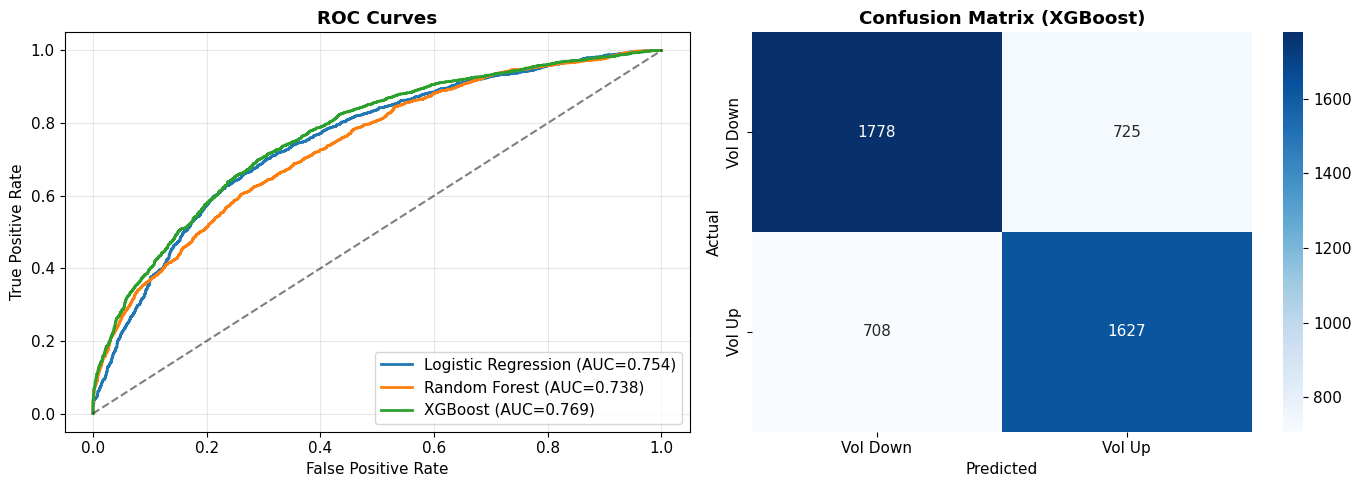

In [27]:
# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['probabilities'])
    ax1.plot(fpr, tpr, label=f"{name} (AUC={res['auc']:.3f})", linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

best_model_name = max(results, key=lambda x: results[x]['auc'])
cm = confusion_matrix(y_test, results[best_model_name]['predictions'])
ax2 = axes[1]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Vol Down', 'Vol Up'], yticklabels=['Vol Down', 'Vol Up'])
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title(f'Confusion Matrix ({best_model_name})', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Feature Importance

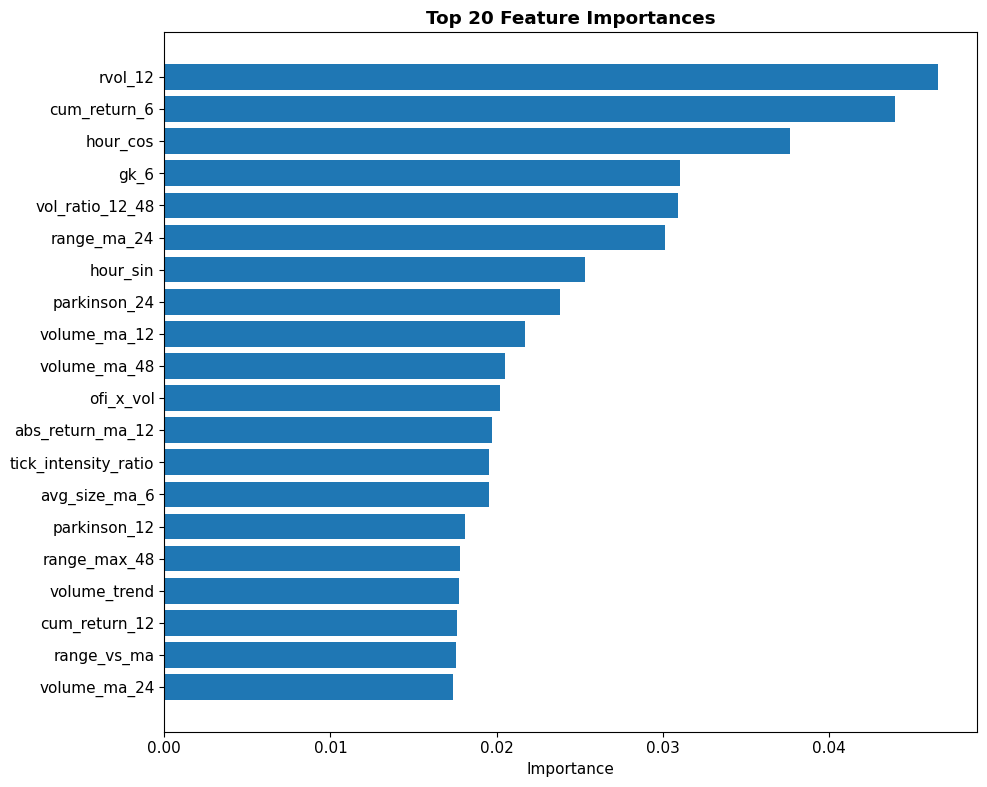

Top 15 Features:
             feature  importance
             rvol_12    0.046585
        cum_return_6    0.043996
            hour_cos    0.037671
                gk_6    0.031042
     vol_ratio_12_48    0.030948
         range_ma_24    0.030132
            hour_sin    0.025306
        parkinson_24    0.023790
        volume_ma_12    0.021709
        volume_ma_48    0.020487
           ofi_x_vol    0.020218
    abs_return_ma_12    0.019699
tick_intensity_ratio    0.019531
       avg_size_ma_6    0.019529
        parkinson_12    0.018125


In [28]:
xgb_model = trained_models['XGBoost']
importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_n = 20
top_features = importance.head(top_n)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print('Top 15 Features:')
print(importance.head(15).to_string(index=False))

## 9. Backtesting

In [29]:
def run_backtest(test_df, predictions, probabilities, horizon=12, transaction_cost=0.001):
    results = []
    for i in range(len(test_df) - horizon):
        prob = probabilities[i]
        signal = 1 if prob > 0.5 else -1
        current_vol = test_df.iloc[i]['rvol_12']
        future_vol = test_df.iloc[i + horizon]['rvol_12']
        if pd.isna(future_vol) or pd.isna(current_vol) or current_vol == 0:
            continue
        vol_change = (future_vol - current_vol) / current_vol
        raw_pnl = signal * vol_change
        net_pnl = raw_pnl - transaction_cost
        results.append({'time': test_df.index[i], 'signal': signal, 'prediction': prob,
                        'vol_change': vol_change, 'net_pnl': net_pnl})
    results_df = pd.DataFrame(results)
    results_df['cum_pnl'] = results_df['net_pnl'].cumsum()
    return results_df

def calculate_metrics(results_df):
    pnl = results_df['net_pnl']
    win_rate = (pnl > 0).mean()
    sharpe = pnl.mean() / pnl.std() * np.sqrt(252 * 12) if pnl.std() > 0 else 0
    cum_pnl = pnl.cumsum()
    max_dd = (cum_pnl - cum_pnl.cummax()).min()
    correct = (((results_df['signal'] > 0) & (results_df['vol_change'] > 0)) |
               ((results_df['signal'] < 0) & (results_df['vol_change'] < 0))).mean()
    return {'total_return': pnl.sum() * 100, 'n_trades': len(pnl), 'win_rate': win_rate,
            'sharpe': sharpe, 'max_dd': max_dd * 100, 'direction_acc': correct}

In [30]:
# Run backtest
best_model_name = max(results, key=lambda x: results[x]['auc'])
print(f'Running backtest with {best_model_name}...')

backtest_results = run_backtest(test_df, results[best_model_name]['predictions'],
                                 results[best_model_name]['probabilities'],
                                 horizon=HORIZON, transaction_cost=TRANSACTION_COST)
metrics = calculate_metrics(backtest_results)

print(f'\nBacktest Results:')
print(f'  Total Return:       {metrics["total_return"]:.2f}%')
print(f'  Win Rate:           {metrics["win_rate"]*100:.1f}%')
print(f'  Direction Accuracy: {metrics["direction_acc"]*100:.1f}%')
print(f'  Sharpe Ratio:       {metrics["sharpe"]:.2f}')
print(f'  Max Drawdown:       {metrics["max_dd"]:.2f}%')
print(f'  Trades:             {metrics["n_trades"]}')

Running backtest with XGBoost...

Backtest Results:
  Total Return:       127509.20%
  Win Rate:           70.4%
  Direction Accuracy: 70.5%
  Sharpe Ratio:       21.57
  Max Drawdown:       -1774.43%
  Trades:             4826


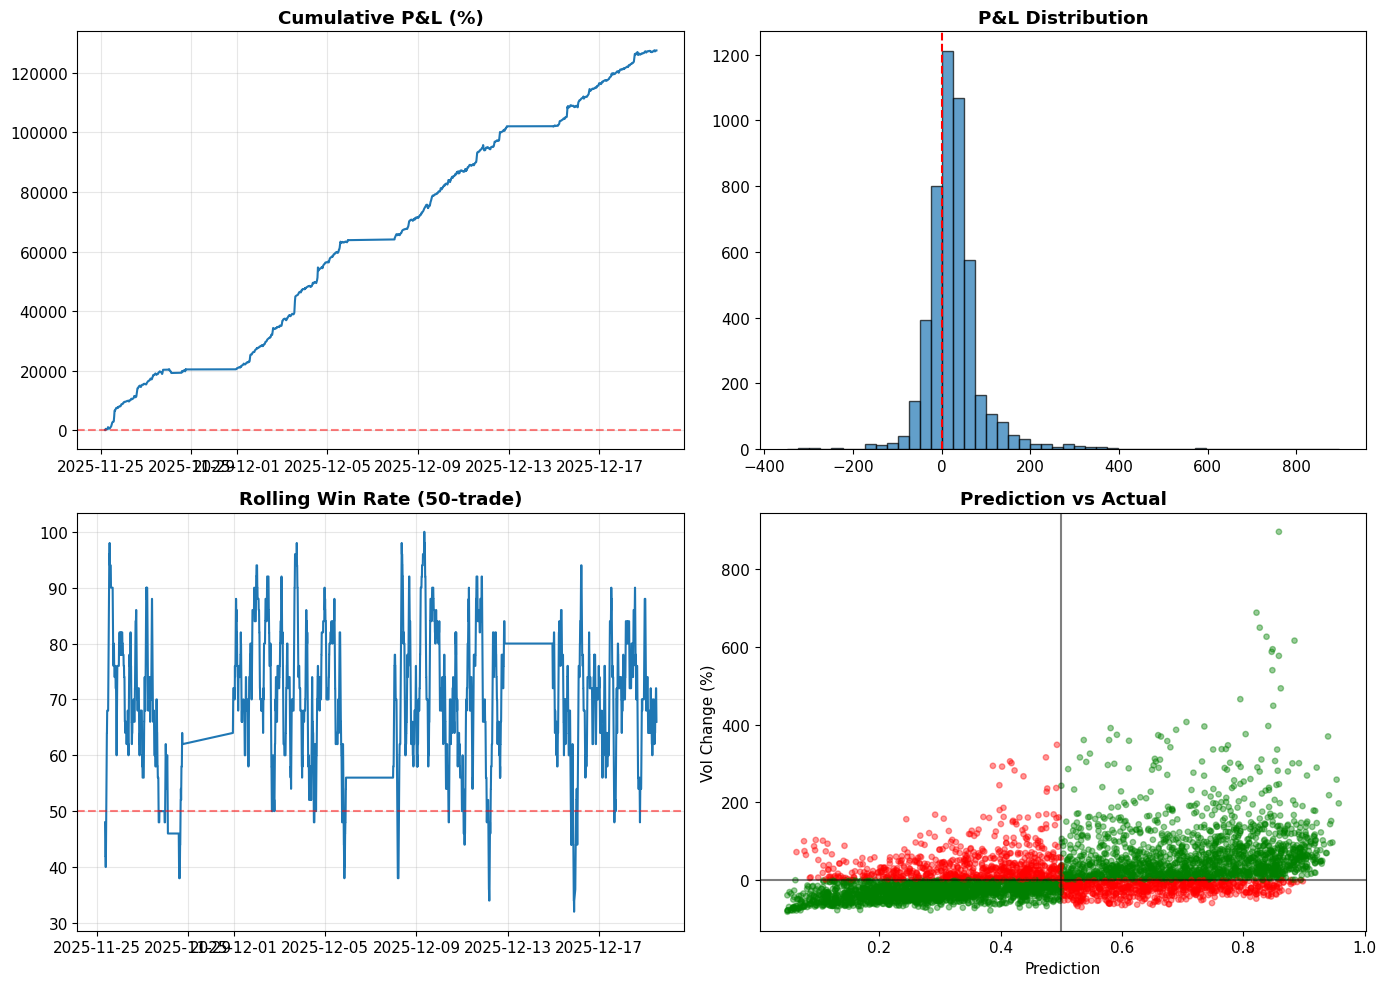

In [31]:
# Plot backtest
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].plot(backtest_results['time'], backtest_results['cum_pnl'] * 100)
axes[0,0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0,0].set_title('Cumulative P&L (%)', fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].hist(backtest_results['net_pnl'] * 100, bins=50, edgecolor='black', alpha=0.7)
axes[0,1].axvline(x=0, color='r', linestyle='--')
axes[0,1].set_title('P&L Distribution', fontweight='bold')

window = min(50, len(backtest_results) // 4)
rolling_wr = (backtest_results['net_pnl'] > 0).rolling(window).mean() * 100
axes[1,0].plot(backtest_results['time'], rolling_wr)
axes[1,0].axhline(y=50, color='r', linestyle='--', alpha=0.5)
axes[1,0].set_title(f'Rolling Win Rate ({window}-trade)', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

correct = (((backtest_results['signal'] > 0) & (backtest_results['vol_change'] > 0)) |
           ((backtest_results['signal'] < 0) & (backtest_results['vol_change'] < 0)))
colors = ['green' if c else 'red' for c in correct]
axes[1,1].scatter(backtest_results['prediction'], backtest_results['vol_change'] * 100, c=colors, alpha=0.4, s=15)
axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1,1].axvline(x=0.5, color='black', linestyle='-', alpha=0.5)
axes[1,1].set_title('Prediction vs Actual', fontweight='bold')
axes[1,1].set_xlabel('Prediction')
axes[1,1].set_ylabel('Vol Change (%)')

plt.tight_layout()
plt.show()

## 10. Walk-Forward Validation

In [32]:
def walk_forward_validation(df, feature_columns, n_splits=4, train_size=0.5):
    n = len(df)
    initial_train = int(n * train_size)
    step_size = (n - initial_train) // n_splits
    results = []
    
    for i in range(n_splits):
        train_end = initial_train + i * step_size
        test_end = min(train_end + step_size, n)
        train = df.iloc[:train_end]
        test = df.iloc[train_end:test_end]
        if len(test) == 0: break
        
        X_train = train[feature_columns].values
        y_train = train['target_vol_up'].values
        X_test = test[feature_columns].values
        y_test = test['target_vol_up'].values
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05,
                                   subsample=0.8, colsample_bytree=0.8, random_state=42,
                                   use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train_scaled, y_train)
        
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        acc = accuracy_score(y_test, model.predict(X_test_scaled))
        
        results.append({'fold': i+1, 'train': len(train), 'test': len(test), 'auc': auc, 'acc': acc})
        print(f'Fold {i+1}: Train={len(train)}, Test={len(test)}, AUC={auc:.4f}, Acc={acc:.4f}')
    
    return pd.DataFrame(results)

print('Walk-Forward Validation:')
print('='*60)
wf_results = walk_forward_validation(df_features, feature_columns, n_splits=4, train_size=0.5)
print(f'\nAverage AUC: {wf_results["auc"].mean():.4f} +/- {wf_results["auc"].std():.4f}')

Walk-Forward Validation:
Fold 1: Train=8062, Test=2015, AUC=0.7767, Acc=0.7102
Fold 2: Train=10077, Test=2015, AUC=0.7551, Acc=0.6844
Fold 3: Train=12092, Test=2015, AUC=0.8011, Acc=0.7290
Fold 4: Train=14107, Test=2015, AUC=0.7666, Acc=0.6948

Average AUC: 0.7749 +/- 0.0196


## 11. Save Model

In [33]:
model_data = {
    'scaler': scaler,
    'models': trained_models,
    'feature_columns': feature_columns,
    'best_model': best_model_name,
    'config': {'symbol': SYMBOL, 'bar_freq': BAR_FREQ, 'horizon': HORIZON}
}

joblib.dump(model_data, 'volatility_forecaster.joblib')
print('Model saved to volatility_forecaster.joblib')

Model saved to volatility_forecaster.joblib


## 12. Summary

In [34]:
print('='*70)
print('                    FINAL SUMMARY')
print('='*70)
print(f'''
Data:
  Symbol: {SYMBOL}
  Bars: {len(bars):,}
  Features: {len(feature_columns)}

Best Model: {best_model_name}
  Test AUC: {results[best_model_name]['auc']:.4f}
  Test Accuracy: {results[best_model_name]['accuracy']:.4f}
  Edge vs Baseline: {(results[best_model_name]['accuracy'] - baseline_acc)*100:+.2f}%

Backtest:
  Total Return: {metrics['total_return']:.2f}%
  Win Rate: {metrics['win_rate']*100:.1f}%
  Sharpe: {metrics['sharpe']:.2f}

Walk-Forward: AUC = {wf_results['auc'].mean():.4f} +/- {wf_results['auc'].std():.4f}
''')

                    FINAL SUMMARY

Data:
  Symbol: NQZ5
  Bars: 16,241
  Features: 65

Best Model: XGBoost
  Test AUC: 0.7693
  Test Accuracy: 0.7038
  Edge vs Baseline: +18.64%

Backtest:
  Total Return: 127509.20%
  Win Rate: 70.4%
  Sharpe: 21.57

Walk-Forward: AUC = 0.7749 +/- 0.0196

